# Info

Setting up the model to recreate the oscillating basin from the non-hydrostatic manual <br>
[Link to the manual](https://oss.deltares.nl/documents/4142077/4199062/non-hydrostatic_report_draft.pdf/eadc1aff-6e19-6e82-2747-3c11c30457ee?t=1624871720408)


Testing the updated xBeach toolbox to see if it can create the non-hydrostatic model

In [27]:
# import default modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os
import subprocess

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"C:\ERDC\xbeach-toolbox")

In [28]:
## import xbeach tools
#sys.path.append(os.path.abspath(os.path.join('..' )))

from xbTools.grid.creation import xgrid, ygrid
from xbTools.grid.extension import seaward_extend
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.general.wave_functions import offshore_depth
from xbTools.xbeachpost import XBeachModelAnalysis

### Import library functions

In [29]:
sys.path.append(r"C:\ERDC\tutorial_models")

from lib.solitary_funcs import (calc_L_scaling, calc_wave_speed, calc_surface_elevation,
                                calc_u_vel, calc_v_vel, calc_depth_average_u)


### Define the model parameters

In [30]:
# Define model parameters
nx = 16000
ny = 2 # This is the slow version of the 1d model
model_time = 40

# Setting the analytical solution time higher than the model time to see if the jump goes away
analy_time = 45
num_analy_times = 1000
# Define paramters for analytical solution
epsilon = 0.3
g  = 9.81
d0 = 1.0


### Calc the analytical solution

In [31]:
# Model parameters
# The model domain length and simulation time also change with the incident wave height

L_sol = calc_L_scaling(epsilon, delta_scaling=1/20) # Length of the solitary wave
model_length = 100 * L_sol                             # Length of the domain
x0 = -2 * L_sol                                     # Initial x-offset

c = calc_wave_speed(g, epsilon, d0)

print("Scaling wave lengths: {}".format(L_sol))
print("Channel Lengths: {}".format(model_length))
print("x0 Locations: {}".format(x0))
print("Wave speed: {}".format(c))

Scaling wave lengths: 4.592201032266706
Channel Lengths: 459.2201032266706
x0 Locations: -9.184402064533412
Wave speed: 3.5641528515017398


In [32]:
# Set the index for the current wave
index = 0

# Select the time arr
time = np.linspace(0, analy_time, num_analy_times)

x_location = 0.0
# Calc the x velocity
u_vel = calc_u_vel(epsilon, x0 = x0, x = x_location, y = d0, t = time, g = g, d0 = d0)

# Calc the y velocity
v_vel = calc_v_vel(epsilon, x0 = x0, x = x_location, y = d0, t = time, g = g, d0 = d0)

# Calc the water surface elevation
eta = calc_surface_elevation(epsilon, x0, x= x_location, t = time, g = g, d0 = d0)

# Calc the average u velocity
u_avg = calc_depth_average_u(epsilon, x0, x = x_location, t = time, g = g, d0 = d0)

In [33]:
# Calc an average V-Velocity to facilate testing

# Init variable to hold the average
v_avg = 0

# Set a tolerance for how much the velocity changes by
num_depths = 100

# Make an array to hold the depths the v-velocity should be calculated at
depths = np.linspace(0, d0, num_depths)


for depth in depths:
    # Calc the v-velocity and sum it
    v_avg += calc_v_vel(epsilon, x0 = x0, x = x_location, 
                        y = depth, t = time, g = g, d0 = d0)

# Average the value
v_avg= v_avg/num_depths

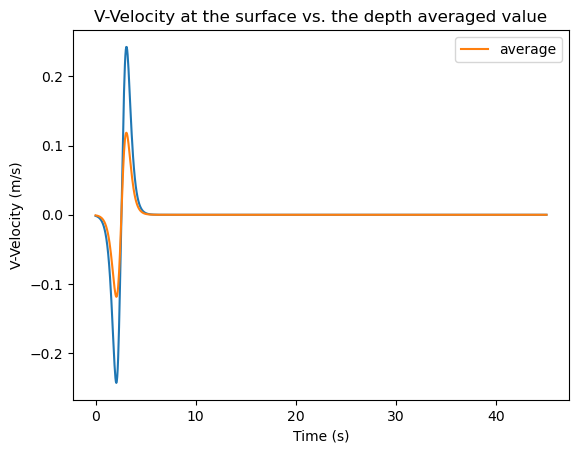

In [34]:
plt.plot(time, v_vel)
plt.plot(time, v_avg, label = "average")

plt.title("V-Velocity at the surface vs. the depth averaged value")
plt.xlabel("Time (s)")
plt.ylabel("V-Velocity (m/s)")
plt.legend()
plt.show()

### Generate the mesh

In [47]:
# Generate the x-mesh
xgr = np.linspace(0, model_length, nx+1)

# Set the y-mesh as none since the model is 1D
ygr = np.linspace(0, 0.1, ny+1)

# Generate the bathymetry
floor_depth = 0.0
zgr = np.ones((ny + 1, nx+1)) * floor_depth

X,Y  = np.meshgrid(xgr, ygr)



In [48]:
# Y.shape
# X.shape
zgr.shape

(3, 16001)

### Create the model setup
Generating the model setup using the xBeach toolbox

In [49]:
xb_setup = XBeachModelSetup('test')

xb_setup.set_grid(X, Y, zgr, posdwn=-1, alfa=0)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

In [50]:
boun_U_dict = {"make_file": True,
               "file_name": "boun_U.bcf",
               "dimension": "vector",
               "variable_dict": {
                   "t" : time,
                   "U" : u_avg, # NOTE: Changed these to surface velocities 
                   "W" : v_avg,
                   "zs": eta - d0 # Pertubation from the intial water surface
               }         
}

xb_setup.set_waves('ts_nonh', input_struct=boun_U_dict)


In [51]:
xb_setup.set_params({"wbctype"      : "ts_nonh",
                     'wavemodel'    : 'nonh',
                     'CFL'          : 0.75,
                    #  'nonhq3d'      : 1,
                    #  'nhlay'        : 0.33, 
                     'viscosity'    : 0, 
                     'lwave'        : 0, 
                     'bedfriccoef'  : 0.0,
                     'morphology'   : 0,
                     'zs0'          : 1,
                     'order'        : 1,
                     'ARC'          : 1, 
                     'front'        : "nonh_1d", 'back'         : "abs_1d" ,
                     'left'         : "neumann", 'right'        : "neumann",

                     'tstop'        : model_time,
                     
                     "tintm"        : 0.1,
                     "tintp"        : 0.1,
                     "tintg"        : 0.1,
                     'nglobalvar'   : ['zs', 'zb', 'H'],
})


In [52]:
xb_setup.input_par

{'par': {},
 'Wave boundary condition parameters': {'wbctype': 'ts_nonh'},
 'Physical processes': {'wavemodel': 'nonh',
  'viscosity': 0,
  'lwave': 0,
  'morphology': 0},
 'Model time': {'CFL': 0.75, 'tstop': 40},
 'Flow parameters': {'bedfriccoef': 0.0},
 'Tide boundary conditions': {'zs0': 1},
 'Flow boundary condition parameters': {'order': 1,
  'ARC': 1,
  'front': 'nonh_1d',
  'back': 'abs_1d',
  'left': 'neumann',
  'right': 'neumann'},
 'Output': {'tintm': 0.1, 'tintp': 0.1, 'tintg': 0.1},
 '_Output': {'nglobalvar': ['zs', 'zb', 'H']}}

In [53]:
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

# Get the folder of the current script
model_dir = get_script_directory()

print("Model directory is: {}".format(model_dir))

xb_setup.write_model(model_dir)

Model directory is: c:\ERDC\tutorial_models\solitary_wave\4_sol_wave_t_stop_40_CFL_075_viscosity_0
Data written to c:\ERDC\tutorial_models\solitary_wave\4_sol_wave_t_stop_40_CFL_075_viscosity_0\boun_U.bcf


### Generate the boun_U.bcf file

In [54]:
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

# Get the folder of the current script
model_dir = get_script_directory()

print("Model directory is: {}".format(model_dir))

Model directory is: c:\ERDC\tutorial_models\solitary_wave\4_sol_wave_t_stop_40_CFL_075_viscosity_0


In [55]:
# Specify the path to your batch file
batch_file = os.path.join(model_dir, r"run_model.bat")

# Run the batch file
try:
    subprocess.run(batch_file, check=True, shell=True)
    print(f"Batch file '{batch_file}' executed successfully.")
except subprocess.CalledProcessError as e:
    raise RuntimeError(f"An error occurred while executing the batch file: {e}")

RuntimeError: An error occurred while executing the batch file: Command 'c:\ERDC\tutorial_models\solitary_wave\4_sol_wave_t_stop_40_CFL_075_viscosity_0\run_model.bat' returned non-zero exit status 1.

In [44]:
results = XBeachModelAnalysis(fname = "foo", 
                              model_path=model_dir)

In [45]:
results.set_save_fig(False)
results.set_plot_localcoords(False)
results.set_plot_km_coords(False)

Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded


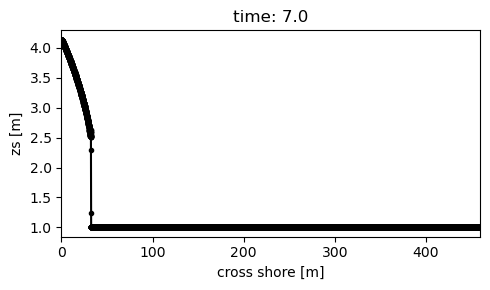

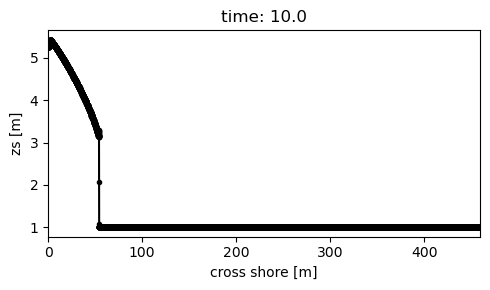

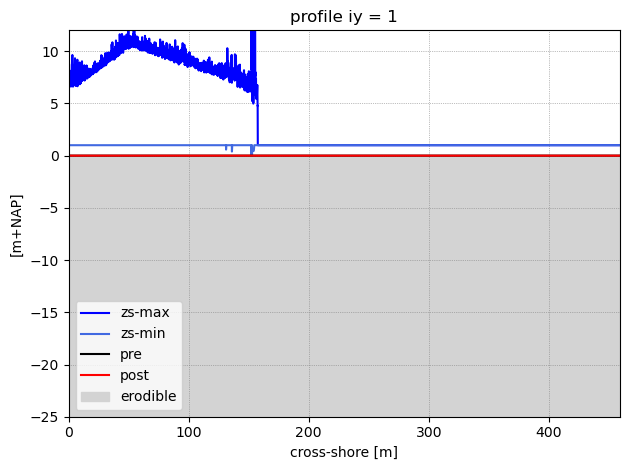

In [60]:
indices = [70, 100]

for index in indices:
    fig, ax = results.fig_cross_var('zs', index, iy=0, coord=None, plot_ref_bathy=False, zmin=-1)

fig, ax = results.fig_profile_change(iy=1)

In [ ]:
time = results.var["globaltime"]
zs = results.var["zs"]

In [ ]:
zs_0 = results.var["zs"][:, 0, 0]
plt.plot(time, zs_0)